<a href="https://colab.research.google.com/github/adeebiscoding/tenserflow/blob/main/NLP_using_PubMedRCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071.

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

>Model 7, which I built, is on par with the model built by the paper (Model 5), but is slightly faster and uses a completely different architecture.

Purpose of the model:

[CLICK HERE](https://camo.githubusercontent.com/685822b9841f09bb871773abdc10c66c3792beb1ec363fb1327c5e90aa695130/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30392d736b696d6c69742d6f766572766965772d696e7075742d616e642d6f75747075742e706e67)

In [1]:
import pandas as pd
import tensorflow as tf

In [221]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-50b6d1ca-b261-67be-d66b-d9294256df2d)


authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Exploring files

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

In [6]:
def get_lines(f_name):
  """
    Reads file name and returns lines of text as list
  """
  with open(f_name, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:1]

['###24293578\n']

In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [9]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [10]:
train_samples[11:20]

[{'target': 'CONCLUSIONS',
  'text': 'low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee oa ( clinicaltrials.gov identifier nct@ ) .',
  'line_number': 11,
  'total_lines': 11},
 {'target': 'BACKGROUND',
  'text': 'emotional eating is associated with overeating and the development of obesity .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'yet , empirical evidence for individual ( trait ) differences in emotional eating and cognitive mechanisms that contribute to eating during sad mood remain equivocal .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'OBJECTIVE',
  'text': 'the aim of this study was to test if attention bias for food moderates the effect of self-reported emotional eating during sad mood ( vs neutral mood ) on actual food intake .',
  'line_number': 2,
  'total_lines': 10},
 {

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


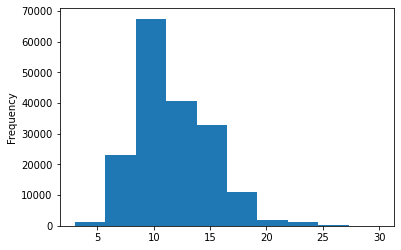

In [13]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

###Get list of sentences

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

## Making numeric labels

###One hot

In [15]:
# one hot
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:

val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

###Label encode

In [17]:
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())


In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Model 0: NB

####V1: using compliment NB

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, CategoricalNB,ComplementNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", ComplementNB()),
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', ComplementNB())])

In [20]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7370250231696015

####V2: using MultinomialNB

In [21]:
# Create a pipeline
model_0_v2 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB()),
])

# Fit the pipeline to the training data
model_0_v2.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset
model_0_v2.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

####V3: using CategoricalNB

(Cant be done with RAM available on Colab Pro)

In [23]:
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [24]:
# Create a pipeline
# model_0_v3 = Pipeline([
#   ("tf-idf", TfidfVectorizer()),
#   ("to_dense", DenseTransformer()),
#   ("clf", CategoricalNB()),
# ])

# # Fit the pipeline to the training data
# model_0_v3.fit(X=train_sentences,
#             y=train_labels_encoded)

In [25]:
# Evaluate baseline model on validation dataset
# model_0_v3.score(X=val_sentences,
#               y=val_labels_encoded)

In [26]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

##Helper func & Model 0 Eval

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [28]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 73.70250231696015,
 'precision': 0.7310403516433973,
 'recall': 0.7370250231696015,
 'f1': 0.732462811484095}

## Preparing data for deep sequence models

making vectorizer and embeddings

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [30]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

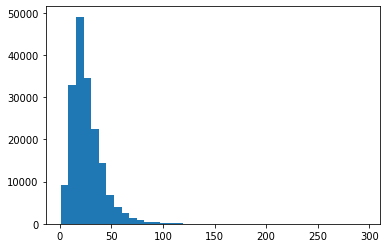

In [31]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=40);

In [32]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### creating vectorizer

In [33]:
max_tokens = 68000

In [34]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
retention in treatment showed no significant differences between treatments ( period @/period @ : srom : @ % / @ % , methadone : @ % / @ % ; period @ : p = @ , period @ : p = @ ) .

Length of text: 45

Vectorized text: [[ 1096     5    19   147    33    37   102    30   377   173   173 17875
   4640   173    14   173    14     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space), if vector has lot of zeros it this will make it more efficient
                               name="token_embedding")

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 retention in treatment showed no significant differences between treatments ( period @/period @ : srom : @ % / @ % , methadone : @ % / @ % ; period @ : p = @ , period @ : p = @ ) .

Sentence after vectorization (before embedding):
 [[ 1096     5    19   147    33    37   102    30   377   173   173 17875
   4640   173    14   173    14     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.00848551 -0.0140276   0.04165485 ...  0.03418554  0.03882894
   -0.02828529]
  [-0.0155009   0.02638074 -0.02351943 ... -0.0183121  -0.0272162
    0.01053869]
  [-0.00903104  0.0266319  -0.00827195 ...  0.00659586  0.03535045
   -0.00327915]
  ...
  [ 0.03788755 -0.03016685  0.02780855 ...  0.03059465 -0.02191186
   -0.02247343]
  [ 0.03788755 -0.03016685  0

Notice how all `0`s are initialized to the same values. model will update and learn patterns and change these values

## Creating datasets 

making our data loads as fast as possible

using `tf.data` API

In [41]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D

In [43]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [45]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))# only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 15s 8ms/step - loss: 0.9234 - accuracy: 0.6362 - val_loss: 0.6859 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6595 - accuracy: 0.7544 - val_loss: 0.6338 - val_accuracy: 0.7686
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6210 - accuracy: 0.7740 - val_loss: 0.5978 - val_accuracy: 0.7869


In [46]:
# Evalaute on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6010 - accuracy: 0.7854


[0.6009812951087952, 0.7854495048522949]

In [47]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[3.98722917e-01, 1.80969015e-01, 8.15421864e-02, 3.16105843e-01,
         2.26600375e-02],
        [4.76668030e-01, 2.26550326e-01, 1.05097685e-02, 2.80210733e-01,
         6.06108410e-03],
        [1.70822948e-01, 1.16726216e-02, 1.58120517e-03, 8.15871000e-01,
         5.21675538e-05],
        ...,
        [2.35420930e-06, 6.44223997e-04, 6.58556703e-04, 2.46932973e-06,
         9.98692453e-01],
        [5.26754633e-02, 4.23352301e-01, 1.20186910e-01, 8.68308321e-02,
         3.16954494e-01],
        [1.87620193e-01, 6.86756551e-01, 3.03904917e-02, 3.61944772e-02,
         5.90383746e-02]], dtype=float32), (30212, 5))

In [48]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.54494902687674,
 'precision': 0.7820841002786171,
 'recall': 0.7854494902687674,
 'f1': 0.7829792561889086}

##Model 2: Feature Extraction with pretrained token embeddingd

### V1 no pool layer

In [50]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [51]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 comparison of a @h on-call shift ( ocd ) compared to a routine working-day ( non on call , noc ) in hospital .
Setence after embedding:
[-0.00070503 -0.04426523  0.02817197 -0.0111308   0.0396011  -0.06680728
  0.07435868  0.0548491   0.00343959  0.04643723  0.0803977   0.00460661
 -0.02827736  0.02621943  0.06077037 -0.04001552 -0.08592364 -0.03947314
  0.02950432  0.06229429 -0.06061932  0.00184389 -0.01509357  0.01656687
  0.04333878 -0.04791442 -0.05313891  0.06652926  0.01090953 -0.01289567]

Length of sentence embedding: 512


In [52]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9191 - accuracy: 0.6481 - val_loss: 0.7982 - val_accuracy: 0.6865
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7710 - accuracy: 0.6995 - val_loss: 0.7571 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7559 - accuracy: 0.7115 - val_loss: 0.7426 - val_accuracy: 0.7101


In [54]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7443 - accuracy: 0.7117


[0.7443405985832214, 0.7116708755493164]

In [55]:
model_2_pred_probs = model_2.predict(valid_dataset)
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 71.16708592612207,
 'precision': 0.7117971242181418,
 'recall': 0.7116708592612208,
 'f1': 0.7085629863965501}

###V2: with avg pooling layer

In [56]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = tf.keras.layers.GlobalAveragePooling1D()(tf.expand_dims(pretrained_embedding, axis =1))
x = layers.Dense(128, activation="relu")(x)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2_v2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2_v2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# Fit model_2 to the data
history_model_2_v2 = model_2_v2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 12ms/step - loss: 0.9165 - accuracy: 0.6452 - val_loss: 0.7981 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7711 - accuracy: 0.7004 - val_loss: 0.7566 - val_accuracy: 0.7078
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7546 - accuracy: 0.7102 - val_loss: 0.7412 - val_accuracy: 0.7148


In [58]:
# Evaluate on the whole validation dataset
model_2_v2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7420 - accuracy: 0.7136


[0.7419531345367432, 0.7136237025260925]

In [59]:
model_2_pred_probs_v2 = model_2_v2.predict(valid_dataset)
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds_v2 = tf.argmax(model_2_pred_probs_v2, axis=1)
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results_v2 = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds_v2)
model_2_results_v2

{'accuracy': 71.36237256719184,
 'precision': 0.7134456417735233,
 'recall': 0.7136237256719185,
 'f1': 0.710701921256428}

###V3: MaxPool

In [60]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = tf.keras.layers.GlobalMaxPooling1D()(tf.expand_dims(pretrained_embedding, axis =1))
x = layers.Dense(128, activation="relu")(x)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2_v3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2_v3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# Fit model_2 to the data
history_model_2_v3 = model_2_v3.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 12ms/step - loss: 0.9183 - accuracy: 0.6483 - val_loss: 0.7969 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7678 - accuracy: 0.7021 - val_loss: 0.7543 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7502 - accuracy: 0.7141 - val_loss: 0.7372 - val_accuracy: 0.7168


In [62]:
# Evaluate on the whole validation dataset
model_2_v3.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7394 - accuracy: 0.7154


[0.7393925189971924, 0.7154110670089722]

In [63]:
model_2_pred_probs_v3 = model_2_v3.predict(valid_dataset)
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds_v3 = tf.argmax(model_2_pred_probs_v3, axis=1)
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results_v3 = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds_v3)
model_2_results_v3

{'accuracy': 71.54110949291672,
 'precision': 0.7157303227843039,
 'recall': 0.7154110949291672,
 'f1': 0.7123084695492397}

## Model 3: Conv1D with char embeddings

### Char level tokenizer

In [64]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'c o m p a r i s o n   o f   a   @ h   o n - c a l l   s h i f t   (   o c d   )   c o m p a r e d   t o   a   r o u t i n e   w o r k i n g - d a y   (   n o n   o n   c a l l   ,   n o c   )   i n   h o s p i t a l   .'

In [65]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

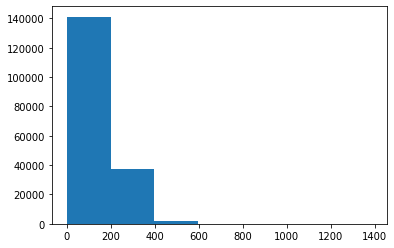

In [67]:
plt.hist(char_lens, bins=7);

In [68]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len, #first output_seq_char_len will be taken into account 
                                    name="char_vectorizer")

In [71]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


###Creating char embedding layer

In [73]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

###Building model

####V1: kernel_size = 5

In [74]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [76]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2793 - accuracy: 0.4852 - val_loss: 1.0642 - val_accuracy: 0.5748
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0204 - accuracy: 0.5937 - val_loss: 0.9527 - val_accuracy: 0.6343
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9321 - accuracy: 0.6360 - val_loss: 0.8780 - val_accuracy: 0.6616


In [77]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.63286111478882,
 'precision': 0.6506872620928065,
 'recall': 0.6563286111478882,
 'f1': 0.6479809380171322}

In [78]:
model_3.evaluate(test_char_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.8958 - accuracy: 0.6528


[0.8957564830780029, 0.6527625918388367]

####V2: kernel_size = 13

In [79]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=13, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3_v2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3_v2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [80]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [81]:
# Fit the model on chars only
model_3_history_v2 = model_3_v2.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 5ms/step - loss: 1.1226 - accuracy: 0.5535 - val_loss: 0.9212 - val_accuracy: 0.6493
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8907 - accuracy: 0.6521 - val_loss: 0.8088 - val_accuracy: 0.6975
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8174 - accuracy: 0.6838 - val_loss: 0.7570 - val_accuracy: 0.7128


In [82]:
# Make predictions with character model only
model_3_pred_probs_v2 = model_3_v2.predict(val_char_dataset)
# Convert prediction probabilities to class labels
model_3_preds_v2 = tf.argmax(model_3_pred_probs_v2, axis=1)
# Calculate results for Conv1D model chars only
model_3_results_v2 = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds_v2)
model_3_results_v2

{'accuracy': 70.10790414404873,
 'precision': 0.6937142097947435,
 'recall': 0.7010790414404873,
 'f1': 0.691660966542244}

In [83]:
model_3_v2.evaluate(test_char_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.7895 - accuracy: 0.6983


[0.789513349533081, 0.6983242034912109]

####V3: kernel_size = 26

In [84]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=26, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3_v3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3_v3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [85]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [86]:
# Fit the model on chars only
model_3_history_v3 = model_3_v3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0965 - accuracy: 0.5608 - val_loss: 0.9161 - val_accuracy: 0.6459
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8863 - accuracy: 0.6561 - val_loss: 0.8131 - val_accuracy: 0.6908
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8250 - accuracy: 0.6823 - val_loss: 0.7822 - val_accuracy: 0.6988


In [87]:
# Make predictions with character model only
model_3_pred_probs_v3 = model_3_v3.predict(val_char_dataset)
# Convert prediction probabilities to class labels
model_3_preds_v3 = tf.argmax(model_3_pred_probs_v3, axis=1)
# Calculate results for Conv1D model chars only
model_3_results_v3 = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds_v3)
model_3_results_v3

{'accuracy': 69.31351780749371,
 'precision': 0.6912671892233959,
 'recall': 0.6931351780749371,
 'f1': 0.6841051199876808}

In [88]:
model_3_v3.evaluate(test_char_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.8029 - accuracy: 0.6937


[0.8029080033302307, 0.6937448382377625]

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

In [89]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

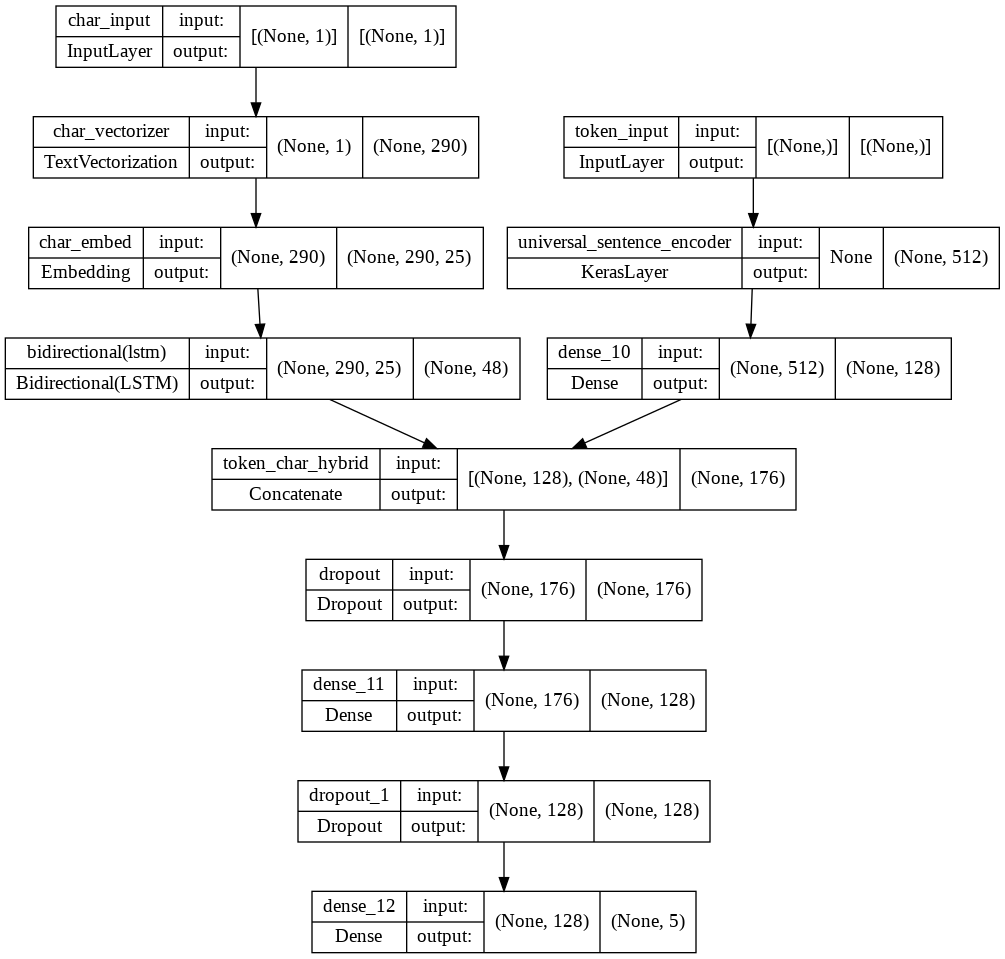

In [90]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

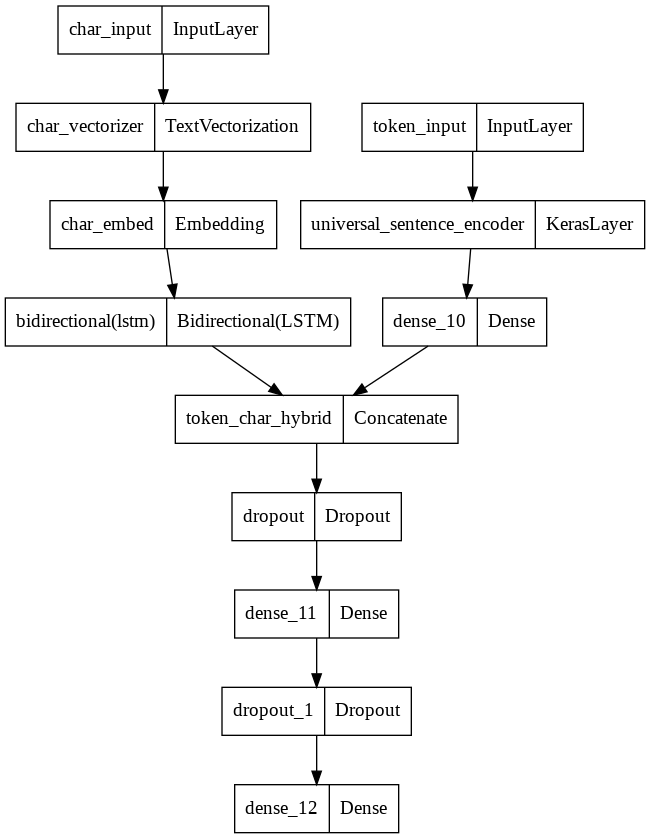

In [91]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [92]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy"])

In [93]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [94]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


remember to have data input in same order as model inputs. model had token first then char, so the `train_char_token_dataset` and `val_char_token_dataset` should also have token and then char

In [95]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Considering the shape, the above blocks **might** be same as `tf.data.Dataset.from_tensor_slices(((val_sentences,val_char_token_data), val_chars))`

In [96]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 34s 45ms/step - loss: 0.9862 - accuracy: 0.6045 - val_loss: 0.7785 - val_accuracy: 0.7045
Epoch 2/3
562/562 [==============================] - 22s 40ms/step - loss: 0.8061 - accuracy: 0.6927 - val_loss: 0.7095 - val_accuracy: 0.7340
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7741 - accuracy: 0.7048 - val_loss: 0.6887 - val_accuracy: 0.7420


In [97]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6914 - accuracy: 0.7364


[0.6914041042327881, 0.7363961338996887]

##Model 5: like model 4 but with poitional embeddings

###Preprocessing

In [98]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [99]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [100]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### BUilding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [176]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input") #train_line_numbers_one_hot[0].shape
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

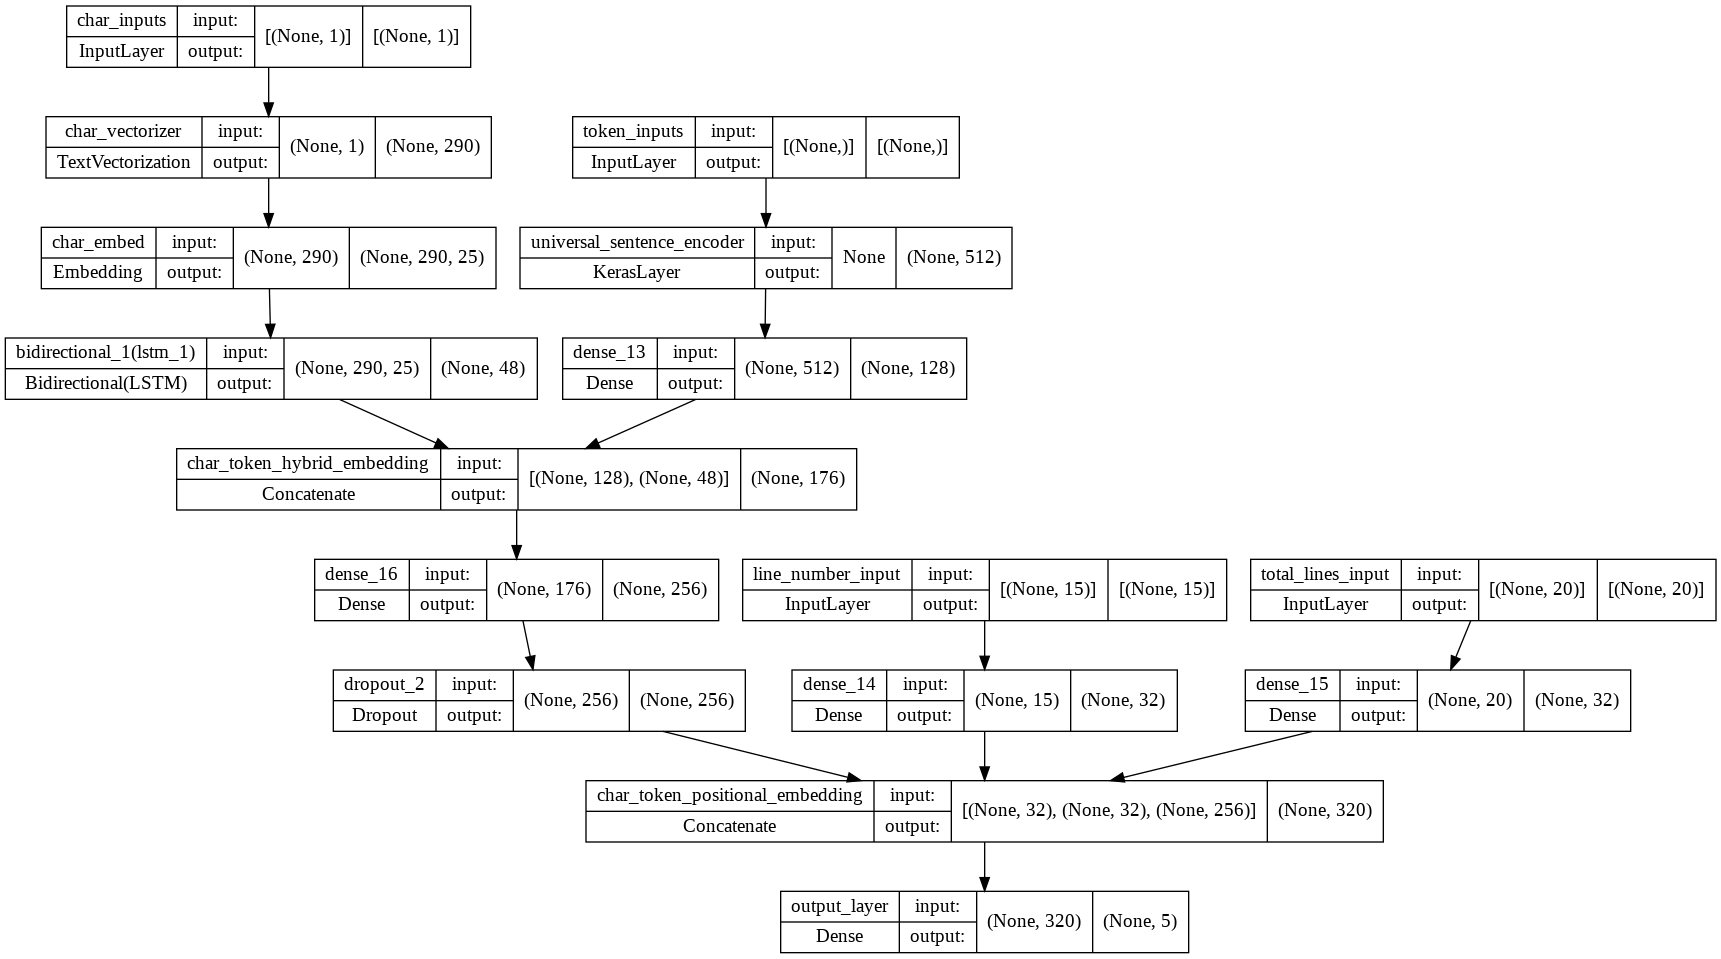

In [102]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [177]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [104]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [178]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 46ms/step - loss: 1.0976 - accuracy: 0.7193 - val_loss: 0.9835 - val_accuracy: 0.8088
Epoch 2/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9683 - accuracy: 0.8137 - val_loss: 0.9500 - val_accuracy: 0.8265
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9514 - accuracy: 0.8224 - val_loss: 0.9394 - val_accuracy: 0.8298


In [179]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 20s 18ms/step


{'accuracy': 83.19541903879252,
 'precision': 0.8307983716411873,
 'recall': 0.8319541903879253,
 'f1': 0.8309195243668737}

##Compare models

In [107]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  #"model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,73.702502,0.731040,0.737025,0.732463
model_1_custom_token_embedding,78.544949,0.782084,0.785449,0.782979
model_2_pretrained_token_embedding,71.167086,0.711797,0.711671,0.708563
model_3_custom_char_embedding,65.632861,0.650687,0.656329,0.647981
model_5_pos_char_token_embedding,83.347676,0.832917,0.833477,0.831912


In [108]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

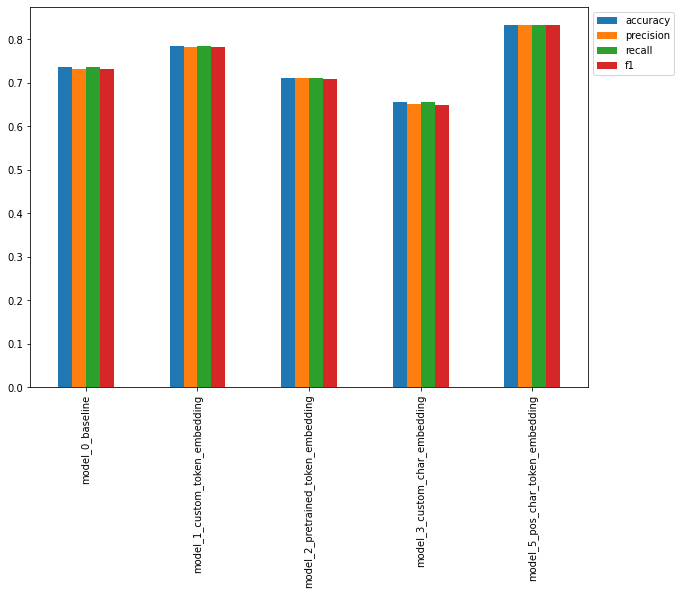

In [109]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

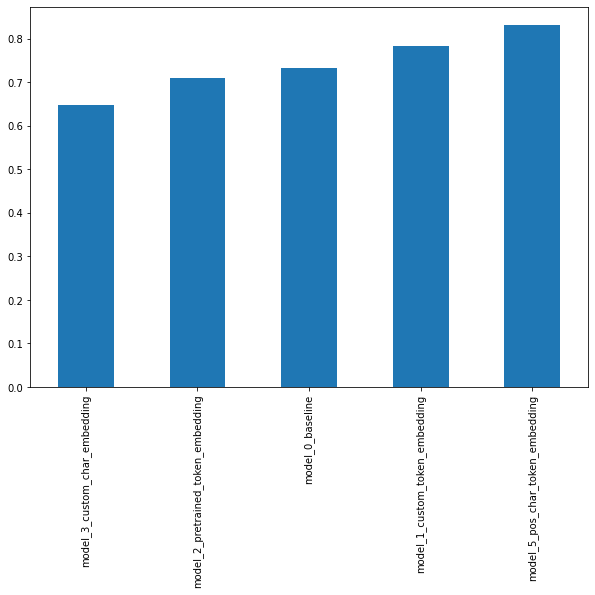

In [110]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

In [111]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input") #train_line_numbers_one_hot[0].shape
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

##Model 6:

Can only Line number and total lines be enough to predict?

####Version 1

In [112]:
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input") #train_line_numbers_one_hot[0].shape
x = layers.Dense(64, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(64, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

step_1 = layers.Concatenate(name = "step_1")([line_number_model.output,
                                              total_lines_model.output])
#---------------------
z = layers.Dense(256, activation="relu")(step_1)
z = layers.Dropout(0.01)(z)
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)
model_6 = tf.keras.Model(inputs=[total_lines_model.input,
                                line_number_model.input
                                ],
                         outputs=output_layer,
                         name="model_6")

In [113]:
# getting data ready

# Create training and valiadation datasets (with all four kinds of input data)
train_pos_data = tf.data.Dataset.from_tensor_slices((
                                                                train_total_lines_one_hot,
                                                                train_line_numbers_one_hot))
train_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_dataset = tf.data.Dataset.zip((train_pos_data, train_pos_labels))
train_pos_dataset = train_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_pos_data = tf.data.Dataset.from_tensor_slices((
                                                              val_total_lines_one_hot,
                                                              val_line_numbers_one_hot))
val_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_dataset = tf.data.Dataset.zip((val_pos_data, val_pos_labels))
val_pos_dataset = val_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [114]:
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [115]:
# Fit our model
history_model_6 = model_6.fit(train_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_dataset)),
                              epochs=3,
                              validation_data=val_pos_dataset,
                              validation_steps=int(0.1 * len(val_pos_dataset)),
                              )

Epoch 1/3
562/562 [==============================] - 2s 3ms/step - loss: 1.0899 - accuracy: 0.6071 - val_loss: 0.9838 - val_accuracy: 0.6705
Epoch 2/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9618 - accuracy: 0.6810 - val_loss: 0.9595 - val_accuracy: 0.6779
Epoch 3/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9510 - accuracy: 0.6846 - val_loss: 0.9611 - val_accuracy: 0.6722


In [116]:
history_model_6 = model_6.fit(train_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_dataset)),
                              epochs=10,
                              initial_epoch = 3,
                              validation_data=val_pos_dataset,
                              validation_steps=int(0.1 * len(val_pos_dataset)),
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = 3)])

Epoch 4/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9631 - accuracy: 0.6769 - val_loss: 0.9425 - val_accuracy: 0.6875
Epoch 5/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9368 - accuracy: 0.6893 - val_loss: 0.9407 - val_accuracy: 0.6862
Epoch 6/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9410 - accuracy: 0.6863 - val_loss: 0.9498 - val_accuracy: 0.6729
Epoch 7/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9347 - accuracy: 0.6901 - val_loss: 0.9471 - val_accuracy: 0.6809


#### Version 2
model 6 with input order switched

In [119]:
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input") #train_line_numbers_one_hot[0].shape
x = layers.Dense(64, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(64, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

step_1 = layers.Concatenate(name = "step_1")([line_number_model.output,
                                              total_lines_model.output])
#---------------------
z = layers.Dense(256, activation="relu")(step_1)
z = layers.Dropout(0.01)(z)
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)
model_6_v2 = tf.keras.Model(inputs=[ line_number_model.input,
                                    total_lines_model.input
                                ],
                         outputs=output_layer,
                         name="model_6")

In [120]:
# getting data ready

# Create training and valiadation datasets (with all four kinds of input data)
train_pos_data2 = tf.data.Dataset.from_tensor_slices((
                                                                train_line_numbers_one_hot,
                                                                train_total_lines_one_hot))
train_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_dataset2 = tf.data.Dataset.zip((train_pos_data2, train_pos_labels))
train_pos_dataset2= train_pos_dataset2.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_pos_data2 = tf.data.Dataset.from_tensor_slices((
                                                              
                                                              val_line_numbers_one_hot,
                                                      val_total_lines_one_hot,))
val_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_dataset2 = tf.data.Dataset.zip((val_pos_data2, val_pos_labels))
val_pos_dataset2 = val_pos_dataset2.batch(32).prefetch(tf.data.AUTOTUNE)


In [121]:
model_6_v2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [122]:
# Fit our model
history_model_6_v2 = model_6_v2.fit(train_pos_dataset2,
                              steps_per_epoch=int(0.1 * len(train_pos_dataset2)),
                              epochs=3,
                              validation_data=val_pos_dataset2,
                              validation_steps=int(0.1 * len(val_pos_dataset2)),
                              )

Epoch 1/3
562/562 [==============================] - 2s 3ms/step - loss: 1.0841 - accuracy: 0.6079 - val_loss: 0.9851 - val_accuracy: 0.6712
Epoch 2/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9616 - accuracy: 0.6824 - val_loss: 0.9628 - val_accuracy: 0.6795
Epoch 3/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9512 - accuracy: 0.6820 - val_loss: 0.9610 - val_accuracy: 0.6722


In [123]:
history_model_6_v2 = model_6_v2.fit(train_pos_dataset2,
                              steps_per_epoch=int(0.1 * len(train_pos_dataset2)),
                              epochs=10,
                              initial_epoch = 3,
                              validation_data=val_pos_dataset2,
                              validation_steps=int(0.1 * len(val_pos_dataset2)),
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = 3)])

Epoch 4/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9631 - accuracy: 0.6769 - val_loss: 0.9439 - val_accuracy: 0.6865
Epoch 5/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9371 - accuracy: 0.6916 - val_loss: 0.9436 - val_accuracy: 0.6868
Epoch 6/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9413 - accuracy: 0.6857 - val_loss: 0.9508 - val_accuracy: 0.6739
Epoch 7/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9348 - accuracy: 0.6897 - val_loss: 0.9476 - val_accuracy: 0.6792
Epoch 8/10
562/562 [==============================] - 2s 3ms/step - loss: 0.9381 - accuracy: 0.6906 - val_loss: 0.9413 - val_accuracy: 0.6805


####Conclusion

Changing order of inputs didnt affect much

##Model 7

1. Concatonate [`line_number`, `Total_lines`]
2. Conatonate [`Conv1D`, `Feature_Extraction`] 
3. Concatonate 1 & 2

In [187]:
# 1. Token inputs
# token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
# token_embeddings = tf_hub_embedding_layer(token_inputs)
# token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
# token_model = tf.keras.Model(inputs=token_inputs,
#                             outputs=token_outputs)

token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
x = layers.Conv1D(64, kernel_size=18, padding="same", activation="relu")(tf.expand_dims(token_embeddings,axis = 1)) #not sure if axis should equal 1 or 0
x = layers.GlobalMaxPool1D()(x)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=x)


# 2. Char inputs
# char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
# char_vectors = char_vectorizer(char_inputs)
# char_embeddings = char_embed(char_vectors)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
# char_model = tf.keras.Model(inputs=char_inputs,
#                             outputs=char_bi_lstm)


#--
# Char input using Model 3 version 2 (best performing)
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=13, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
char_model = tf.keras.Model(inputs=inputs,
                         outputs=x,
                         name="char_model")
#--

#Line numbers model

line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input") #train_line_numbers_one_hot[0].shape
# dense layer with 32 units & relu activation
dense_layer = layers.Dense(64, activation="tanh")(line_number_inputs)
x = layers.Dense(32, activation="relu")(dense_layer)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
dense_layer = layers.Dense(64, activation="tanh")(total_lines_inputs)
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
char_token_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

# z = layers.Dense(256, activation="relu")(combined_embeddings)
# z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
pos_embeddings = layers.Concatenate(name="positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 #z
                                                                                 ])

# 7. Create output layer

final_concat = layers.Concatenate(name="final_concat")([char_token_embeddings, pos_embeddings ])

output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(final_concat)

# 8. Put together model with all kinds of inputs
model_7 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_7")

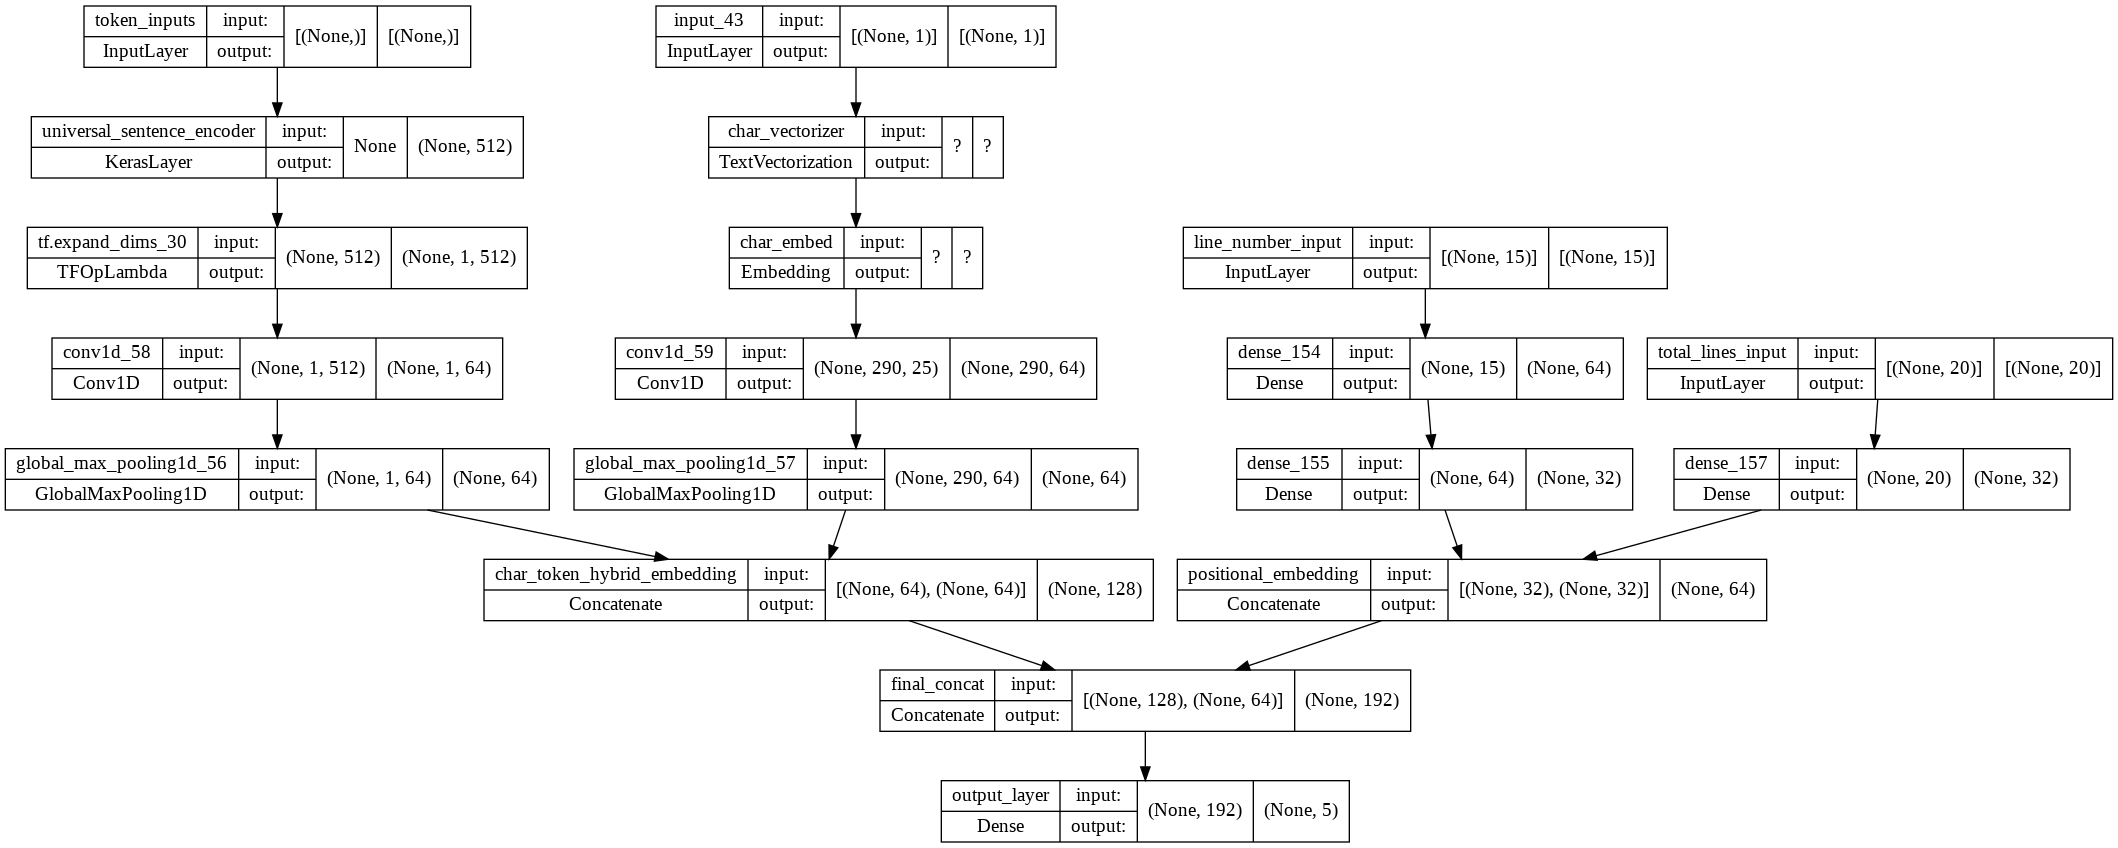

In [188]:
plot_model(model_7, show_shapes=True)

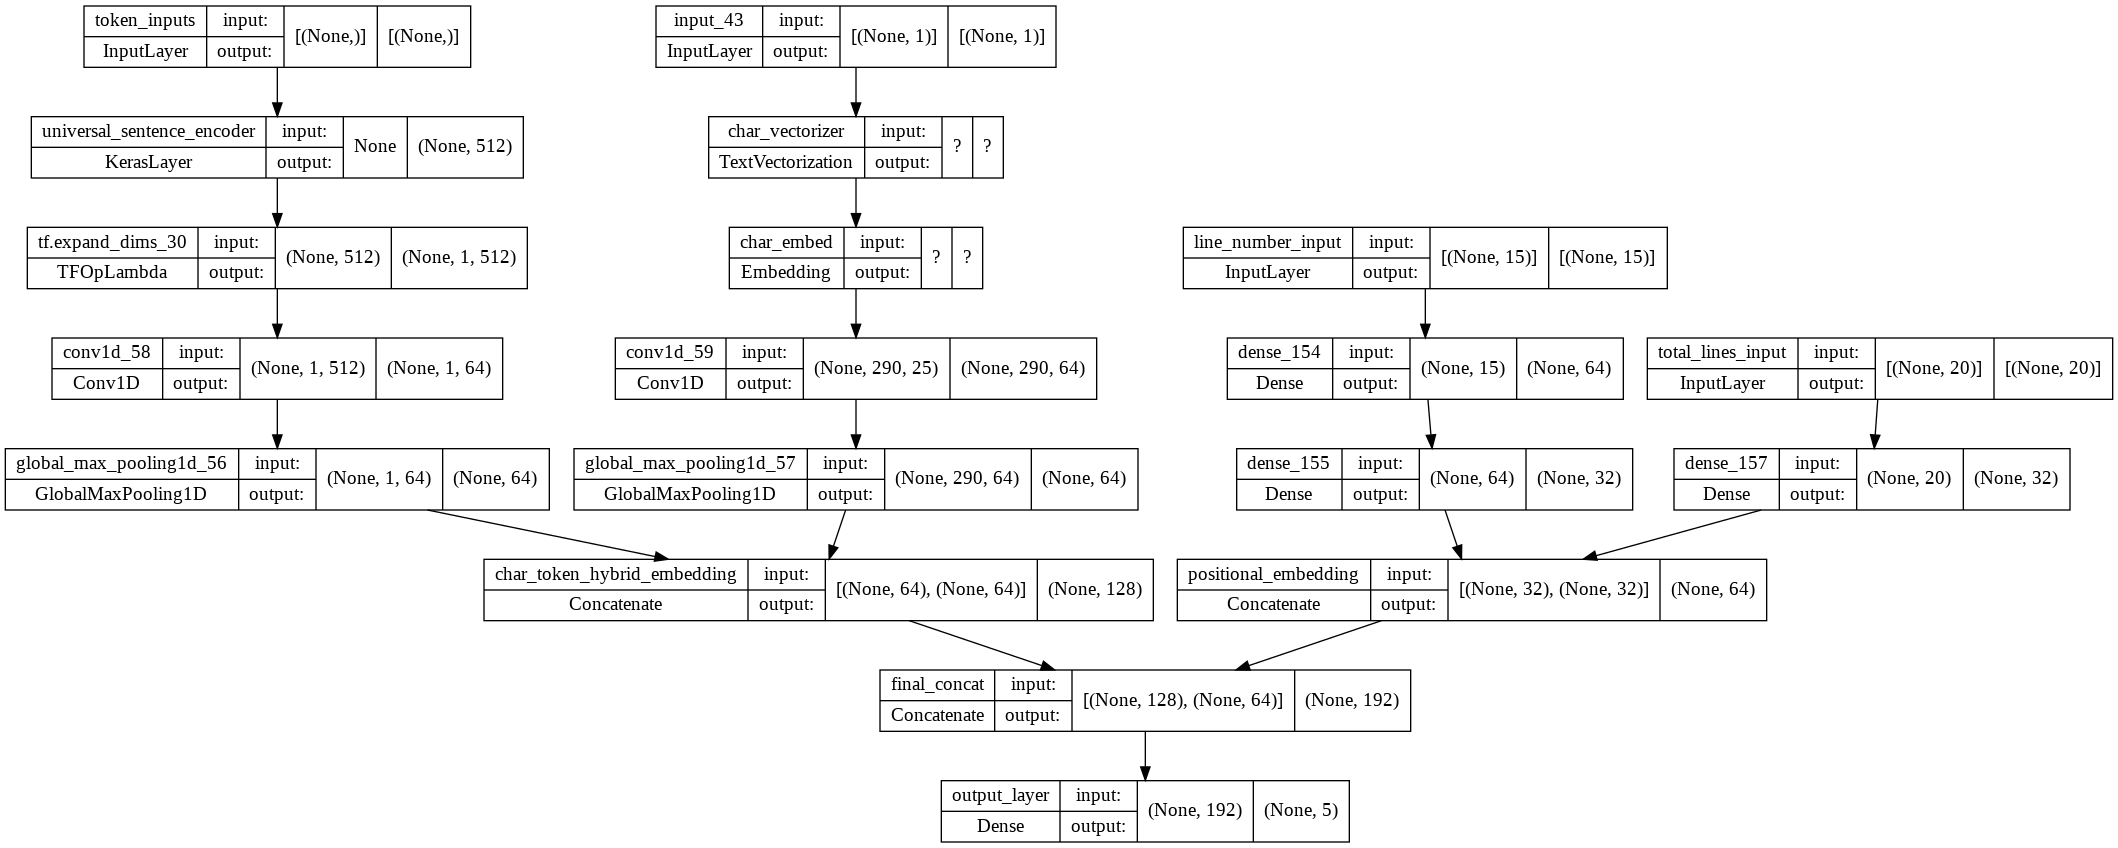

In [189]:
plot_model(model_7, show_shapes=True)

In [190]:
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [191]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [192]:
# Fit our tribrid embedding model
history_model_7 = model_7.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 15ms/step - loss: 0.8889 - accuracy: 0.7469 - val_loss: 0.7772 - val_accuracy: 0.8138
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7545 - accuracy: 0.8225 - val_loss: 0.7451 - val_accuracy: 0.8301
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7372 - accuracy: 0.8319 - val_loss: 0.7259 - val_accuracy: 0.8354


In [172]:
history_model_7 = model_7.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=12,
                              initial_epoch = 3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 2)])

Epoch 4/12
562/562 [==============================] - 8s 14ms/step - loss: 0.7253 - accuracy: 0.8427 - val_loss: 0.7185 - val_accuracy: 0.8481
Epoch 5/12
562/562 [==============================] - 8s 14ms/step - loss: 0.7010 - accuracy: 0.8522 - val_loss: 0.7133 - val_accuracy: 0.8441
Epoch 6/12
562/562 [==============================] - 8s 14ms/step - loss: 0.6961 - accuracy: 0.8574 - val_loss: 0.7093 - val_accuracy: 0.8494
Epoch 7/12
562/562 [==============================] - 8s 14ms/step - loss: 0.7118 - accuracy: 0.8504 - val_loss: 0.7069 - val_accuracy: 0.8511
Epoch 8/12
562/562 [==============================] - 8s 14ms/step - loss: 0.7125 - accuracy: 0.8482 - val_loss: 0.7029 - val_accuracy: 0.8547
Epoch 9/12
562/562 [==============================] - 8s 14ms/step - loss: 0.7159 - accuracy: 0.8445 - val_loss: 0.6979 - val_accuracy: 0.8600
Epoch 10/12
562/562 [==============================] - 8s 14ms/step - loss: 0.7019 - accuracy: 0.8545 - val_loss: 0.6955 - val_accuracy: 0.861

###Comparing with model 5

before that we need to fir model 3 for 12 epochs to get for equality sake

In [180]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=12,
                              initial_epoch = 3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 2)])

Epoch 4/12
562/562 [==============================] - 23s 41ms/step - loss: 0.9421 - accuracy: 0.8283 - val_loss: 0.9278 - val_accuracy: 0.8447
Epoch 5/12
562/562 [==============================] - 23s 41ms/step - loss: 0.9240 - accuracy: 0.8453 - val_loss: 0.9208 - val_accuracy: 0.8464
Epoch 6/12
562/562 [==============================] - 21s 37ms/step - loss: 0.9196 - accuracy: 0.8453 - val_loss: 0.9208 - val_accuracy: 0.8444
Epoch 7/12
562/562 [==============================] - 24s 43ms/step - loss: 0.9265 - accuracy: 0.8453 - val_loss: 0.9178 - val_accuracy: 0.8421


In [173]:
# Make predictions with the char token pos model
model_7_pred_probs = model_7.predict(val_char_token_pos_dataset, verbose=1)
# Convert pred probs to pred labels
model_7_preds = tf.argmax(model_7_pred_probs, axis=1)
# Calculate results of char token pos model
model_7_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_7_preds)
model_7_results

945/945 [==============================] - 9s 9ms/step


{'accuracy': 86.06513967959751,
 'precision': 0.8674723879850698,
 'recall': 0.8606513967959751,
 'f1': 0.8559027390616799}

In [181]:
model_5_results

{'accuracy': 83.19541903879252,
 'precision': 0.8307983716411873,
 'recall': 0.8319541903879253,
 'f1': 0.8309195243668737}

###Conclusion

model 7 was the best model, both in terms of accuracy and interms of speed 

##Evaluating Model 7

Since model 7 was our best model **yet**, lets dig in further and see where it went wrong

In [202]:
test_pred_class = [label_encoder.classes_[pred] for pred in model_7_preds]

In [218]:
test_df = pd.DataFrame(val_samples)

In [219]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_class # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(model_7_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"]

In [220]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
2029,METHODS,vo@ pic increased after at ( @ @ vs @ @ ml o@/...,4,8,RESULTS,0.982185,False
2320,METHODS,group differences in madrs scores over time we...,10,13,RESULTS,0.981877,False
16074,RESULTS,patient-level analyses were conducted using ge...,3,11,METHODS,0.978564,False
25375,METHODS,thromboses were more commonly incident ( n = @...,10,15,RESULTS,0.974912,False
15119,METHODS,"nebivolol reduced hvpg from @ mm hg ( sd , @ )...",6,8,RESULTS,0.972569,False
...,...,...,...,...,...,...,...
28492,CONCLUSIONS,clinicaltrials.gov id : nct@ .,15,15,BACKGROUND,0.923130,False
16599,RESULTS,all were examined by an ophthalmologist and ei...,4,13,METHODS,0.922315,False
24386,RESULTS,"saffron can decrease antihsp@ , @ levels in pa...",8,9,CONCLUSIONS,0.922185,False
1252,RESULTS,"after a @-week run-in period , participants we...",3,11,METHODS,0.921993,False


##Next Steps

We can go through the wrong labels, and see if there are any mislabelled and fix that. After thi, retrain the model. The process of using a model to help improve/investigate your dataset's labels is often referred to as **active learning**.